In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy.typing import NDArray

In [19]:
class Perceptron:
    """
    Implementação simples de um neurônio artificial (Perceptron).
    """
    def __init__(self, learning_rate: float = 0.01, n_iterations: int = 1000, random_state: int = 42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.weights: NDArray[np.float64] | None = None
        self.bias: float = 0.0
        self.errors_history: list[int] = []
        
    def _activation(self, x: NDArray[np.float64]) -> NDArray[np.int64]:
        """Função de ativação degrau (Step Function): Retorna 1 se x >= 0, senão 0."""
        return np.where(x >= 0, 1, 0)
    
    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> 'Perceptron':
        """
        Treina o modelo ajustando pesos e bias.
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Inicializa pesos (pequenos valores aleatórios) e bias (0)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0
        
        # Loop de treinamento (Épocas)
        for _ in range(self.n_iterations):
            errors = 0
            
            for idx, x_i in enumerate(X):
                # Cálculo da saída linear (z = w * x + b)
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self._activation(linear_output)
                
                # Regra de atualização do Perceptron
                # Se erro != 0, ajusta pesos e bias
                update = self.learning_rate * (y[idx] - y_predicted)
                
                self.weights += update * x_i
                self.bias += update
                
                errors += int(update != 0.0)
            
            self.errors_history.append(errors)
            
            # Para o treino antecipadamente se convergir (0 erros)
            if errors == 0:
                break
        
        return self
    
    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Realiza predições em novos dados."""
        if self.weights is None:
            raise ValueError("O modelo precisa ser treinado antes de fazer predições")
        
        linear_output = np.dot(X, self.weights) + self.bias
        return self._activation(linear_output)
    

In [20]:
# --- Preparação dos Dados (Data Prep) ---

# 1. Carrega o dataset
df = pd.read_csv('cvd/data.csv')

# 2. Seleção e Limpeza
# O Perceptron só aceita números. Selecionamos colunas relevantes numéricas/binárias.
# Vamos usar: Idade, Visitou Wuhan, É de Wuhan, Gênero.
# Alvo: Death (0 ou 1)
colunas_interesse = ['age', 'vis_wuhan', 'from_wuhan', 'gender', 'death']
features_cols = ['age', 'vis_wuhan', 'from_wuhan', 'gender'] # Guardamos os nomes

# Remove linhas com valores vazios (NA) nessas colunas específicas
df_clean = df[colunas_interesse].dropna().copy()

# Converte Gênero para número (Male: 1, Female: 0)
df_clean['gender'] = df_clean['gender'].map({'male': 1, 'female': 0})

# 3. Separar Features (X) e Target (y)
X = df_clean.drop('death', axis=1).values
y = df_clean['death'].values.astype(int) # Garante que é inteiro

# 4. Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Normaliza os dados (Essencial para o Perceptron convergir mais rápido)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Acurácia no conjunto de teste: 0.9030 (90.30%)

--- Estrutura da Rede ---
Camada de Entrada (Inputs): 4 nós (['age', 'vis_wuhan', 'from_wuhan', 'gender'])
Camada de Saída (Output):   1 neurônio
Total de Pesos ajustados:   4
Valor do Bias final:        -0.0600


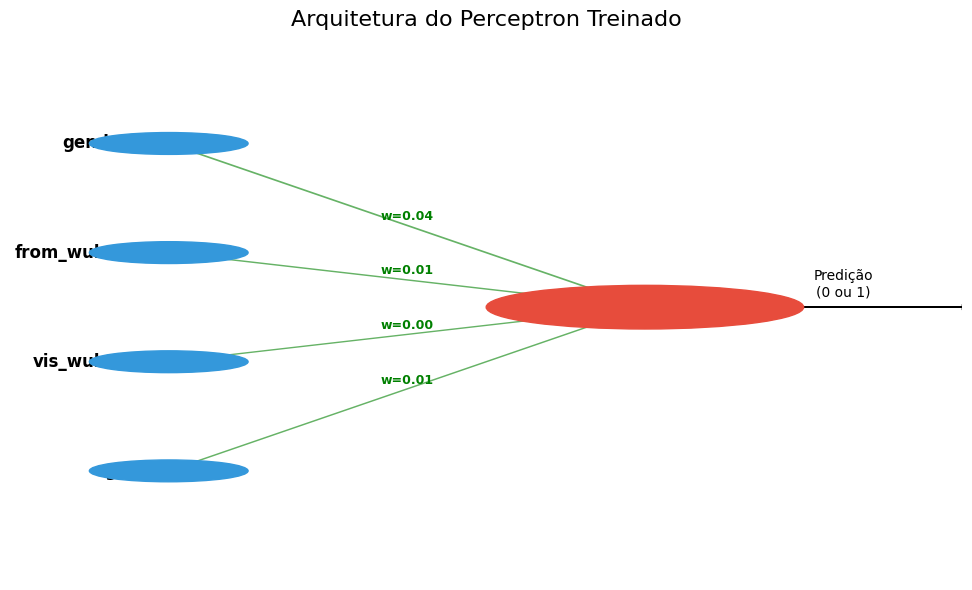

In [22]:
# --- Execução do Modelo ---

# Treina o Perceptron
perceptron = Perceptron(learning_rate=0.01, n_iterations=1000, random_state=42)
perceptron.fit(X_train_scaled, y_train)

# Calcula acurácia
y_test_pred = perceptron.predict(X_test_scaled)
accuracy = np.mean(y_test_pred == y_test)
print(f"Acurácia no conjunto de teste: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- 4. Exibição da Arquitetura (NOVO) ---
print("\n--- Estrutura da Rede ---")
print(f"Camada de Entrada (Inputs): {len(features_cols)} nós ({features_cols})")
print(f"Camada de Saída (Output):   1 neurônio")
print(f"Total de Pesos ajustados:   {len(perceptron.weights)}")
print(f"Valor do Bias final:        {perceptron.bias:.4f}")

def plot_network_structure(weights, feature_names):
    n_inputs = len(weights)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Coordenadas
    left_x = 0.2
    right_x = 0.8
    y_center = (n_inputs - 1) / 2
    
    # Desenhar conexões
    for i in range(n_inputs):
        # Cor da linha baseada no peso (Verde=Positivo, Vermelho=Negativo)
        color = 'green' if weights[i] > 0 else 'red'
        thickness = 1 + abs(weights[i]) * 5  # Espessura proporcional à importância
        
        # Linha do input i até o neurônio único
        ax.plot([left_x, right_x], [i, y_center], c=color, linewidth=thickness, alpha=0.6)
        
        # Texto do peso na linha
        ax.text((left_x+right_x)/2, (i+y_center)/2 + 0.05, f"w={weights[i]:.2f}", 
                ha='center', fontsize=9, color=color, fontweight='bold')
        
        # Desenhar Nó de Entrada
        circle = plt.Circle((left_x, i), 0.1, color='#3498db', zorder=10)
        ax.add_artist(circle)
        ax.text(left_x - 0.05, i, feature_names[i], ha='right', va='center', fontsize=12, fontweight='bold')

    # Desenhar Nó de Saída (Neurônio Único)
    circle_out = plt.Circle((right_x, y_center), 0.2, color='#e74c3c', zorder=10)
    ax.add_artist(circle_out)
    ax.text(right_x, y_center, "Neurônio\nΣ + Step", ha='center', va='center', color='white', fontweight='bold')
    
    # Seta de saída
    ax.arrow(right_x + 0.2, y_center, 0.2, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')
    ax.text(right_x + 0.25, y_center + 0.1, "Predição\n(0 ou 1)", ha='center')

    # Configuração do gráfico
    ax.set_xlim(0, 1.2)
    ax.set_ylim(-1, n_inputs)
    ax.axis('off')
    ax.set_title("Arquitetura do Perceptron Treinado", fontsize=16)
    plt.tight_layout()
    plt.show()

# Chama a função de desenho
plot_network_structure(perceptron.weights, features_cols)